In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, LeakyReLU
from keras.layers import Input, UpSampling2D,BatchNormalization, ZeroPadding2D, Reshape, Permute
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import cv2

In [13]:
def fcn32_model(input_shape, n_classes):
    inputs = Input(input_shape)

    # Block 1
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1)

    # Block 2
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2)

    # Block 3
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3)

    # Block 4
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4)

    # Block 5
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5)

    # Convolutional layers transferred from fully connected layers
    conv6 = Conv2D(4096, (7, 7), activation='relu', padding='same')(pool5)
    conv6 = tf.keras.layers.Dropout(0.5)(conv6)
    conv7 = Conv2D(4096, (1, 1), activation='relu', padding='same')(conv6)
    conv7 = tf.keras.layers.Dropout(0.5)(conv7)

    # Score from conv7
    score_conv7 = Conv2D(n_classes, (1, 1), activation=None, padding='same')(conv7)

    # Upsampling
    upscore32 = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(32, 32), padding='same')(score_conv7)

    outputs = tf.keras.layers.Activation('sigmoid')(upscore32)

    model = Model(inputs, outputs)

    return model


In [14]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [15]:
from keras.utils import to_categorical

images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(256, 256))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(256, 256), grayscale=True)

#masks = to_categorical(masks, num_classes=2)

In [16]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [17]:
n_classes = 1
model = fcn32_model((256,256, 3), n_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(images_train, masks_train, epochs=30, batch_size=16, validation_data = (images_test, masks_test))

Epoch 1/30
42/42 [==============================] - 37s 755ms/step - loss: 0.6100 - accuracy: 0.7887 - val_loss: 0.4183 - val_accuracy: 0.8551
Epoch 2/30
42/42 [==============================] - 30s 723ms/step - loss: 0.3169 - accuracy: 0.8480 - val_loss: 0.2781 - val_accuracy: 0.8563
Epoch 3/30
42/42 [==============================] - 31s 728ms/step - loss: 0.2839 - accuracy: 0.8495 - val_loss: 0.2927 - val_accuracy: 0.8563
Epoch 4/30
42/42 [==============================] - 31s 734ms/step - loss: 0.2867 - accuracy: 0.8514 - val_loss: 0.2724 - val_accuracy: 0.8582
Epoch 5/30
42/42 [==============================] - 30s 720ms/step - loss: 0.2830 - accuracy: 0.8532 - val_loss: 0.2739 - val_accuracy: 0.8608
Epoch 6/30
42/42 [==============================] - 31s 729ms/step - loss: 0.2813 - accuracy: 0.8539 - val_loss: 0.2766 - val_accuracy: 0.8607
Epoch 7/30
42/42 [==============================] - 30s 721ms/step - loss: 0.2225 - accuracy: 0.8837 - val_loss: 0.1265 - val_accuracy: 0.9308

In [18]:
results = model.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.5, 1, 0), axis=-1)

6/6 [==============================] - 11s 276ms/step


In [19]:
results[0].shape

(256, 256, 1)

In [20]:
loss, acc = model.evaluate(images_test, masks_test)
loss, acc

6/6 [==============================] - 2s 295ms/step - loss: 0.0493 - accuracy: 0.9616


(0.04930819571018219, 0.9615530967712402)

In [21]:
model.save('fcn32.h5')

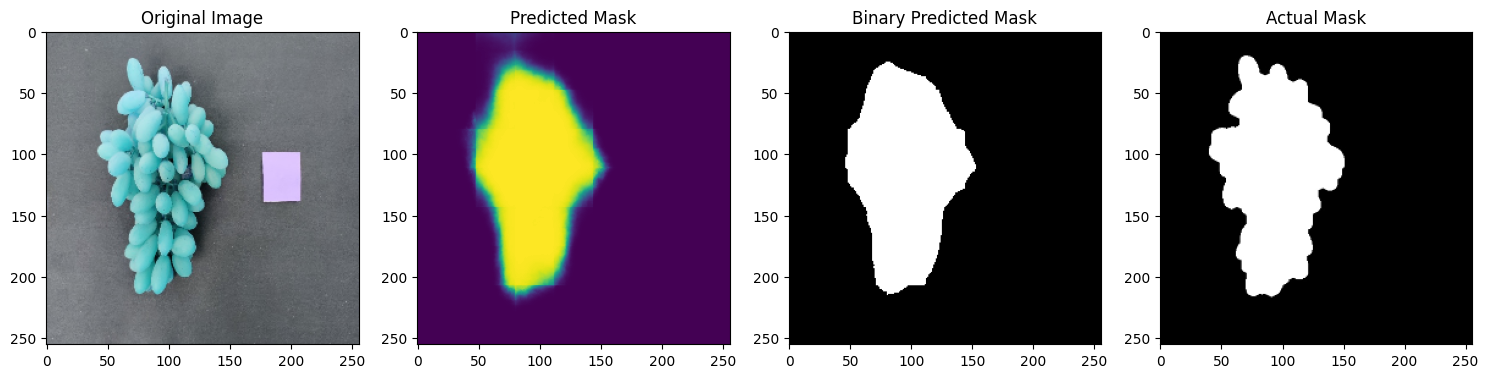

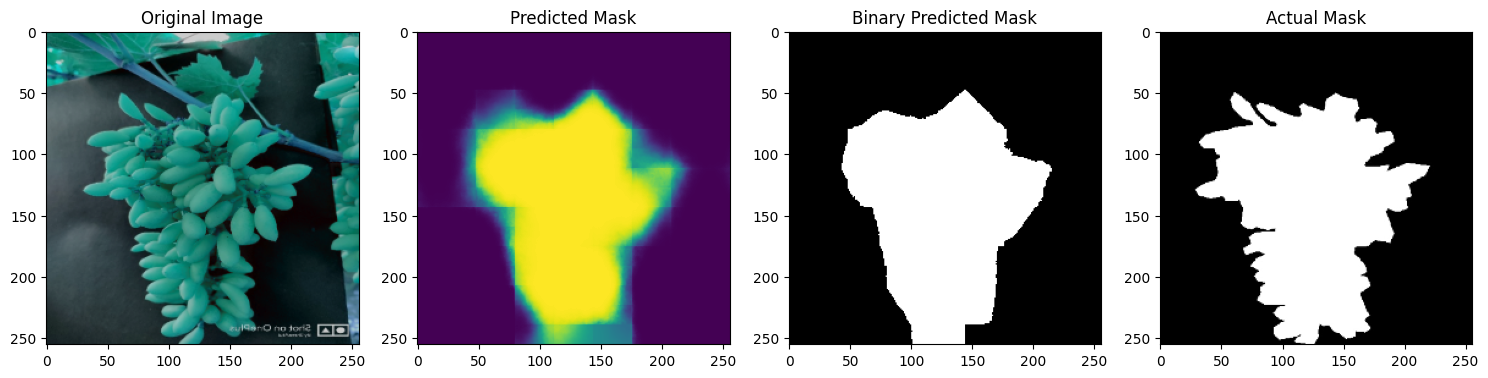

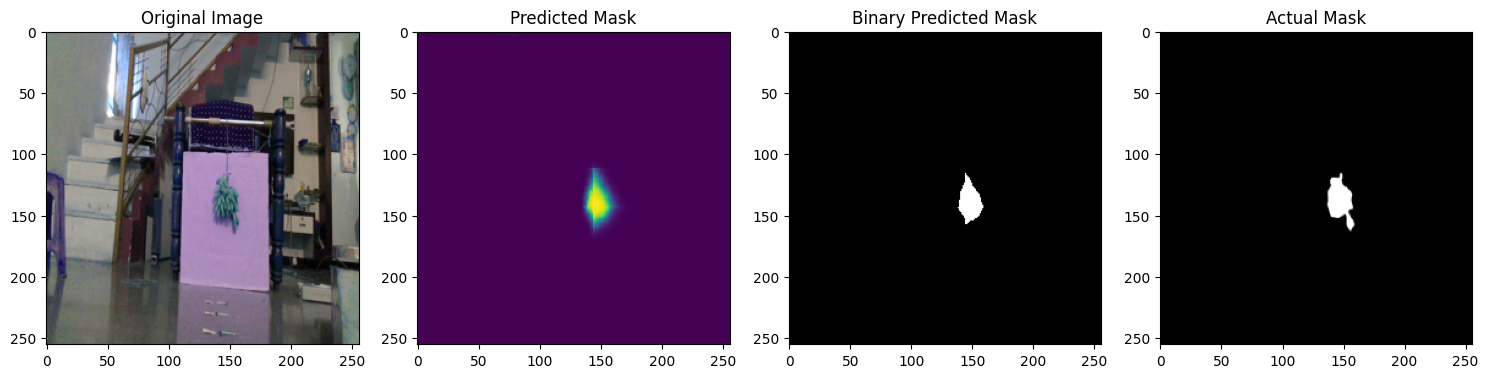

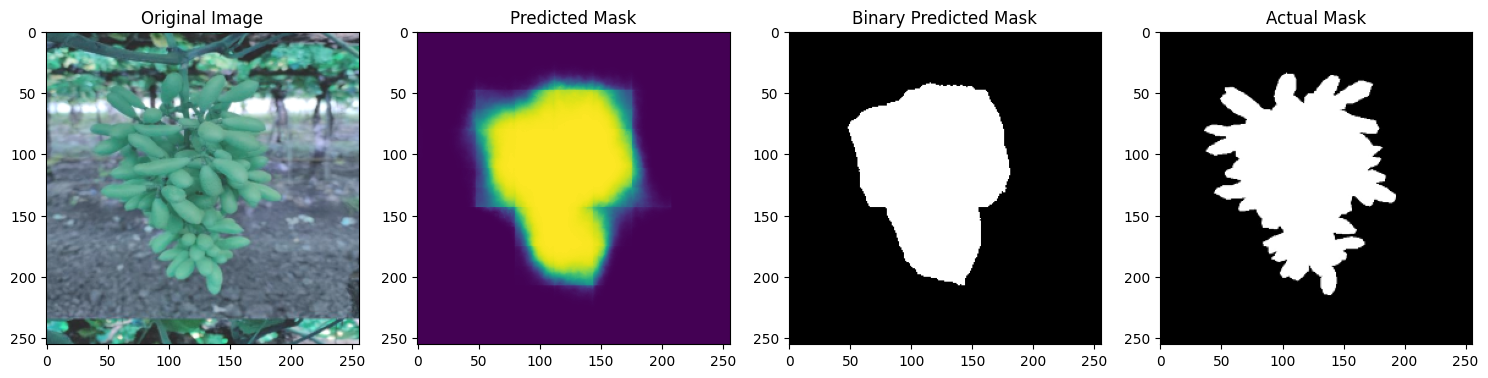

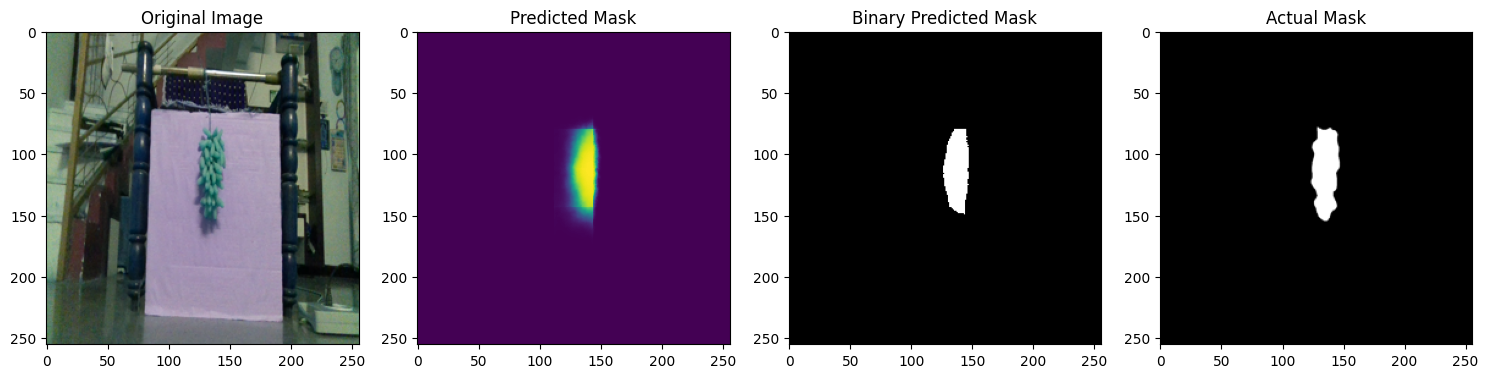

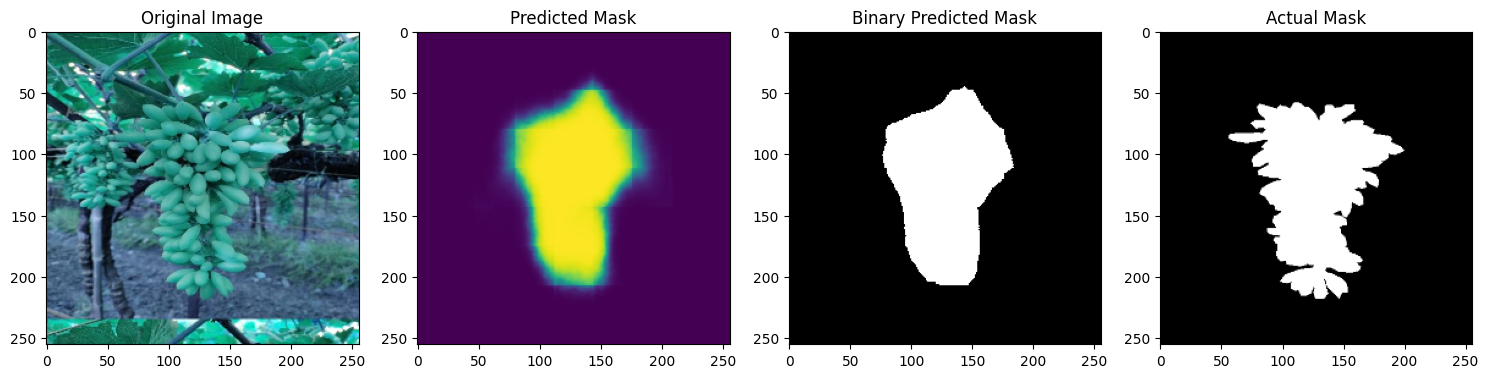

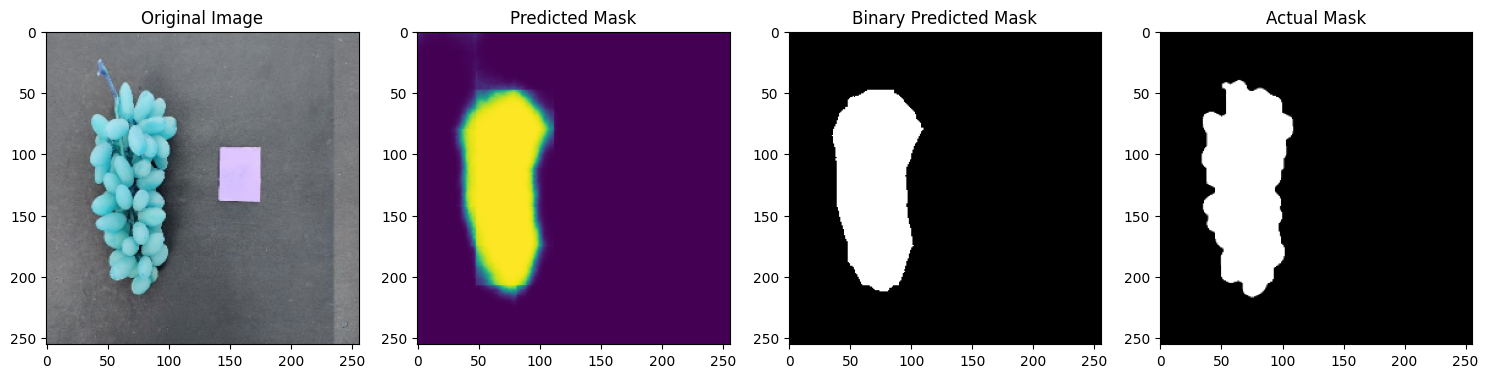

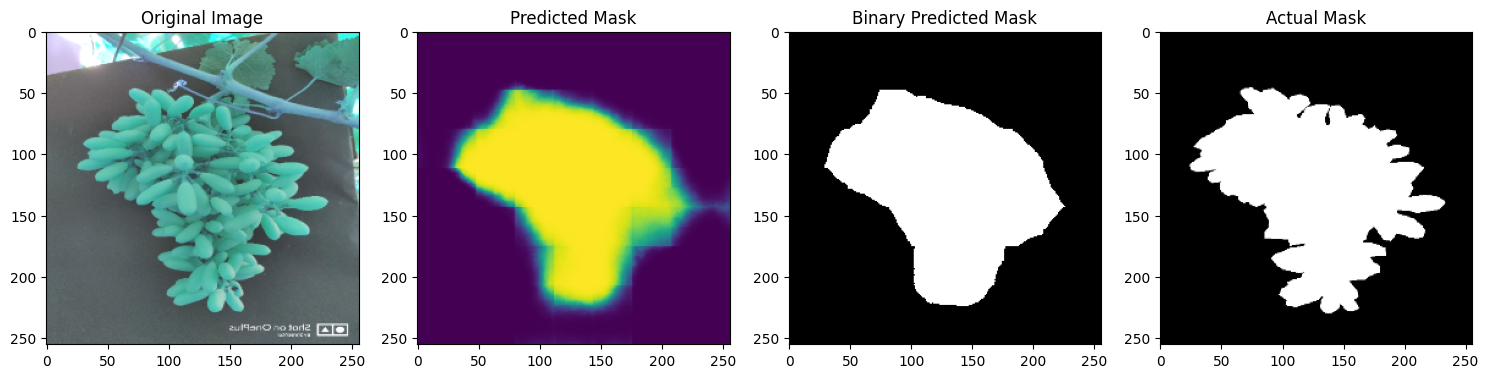

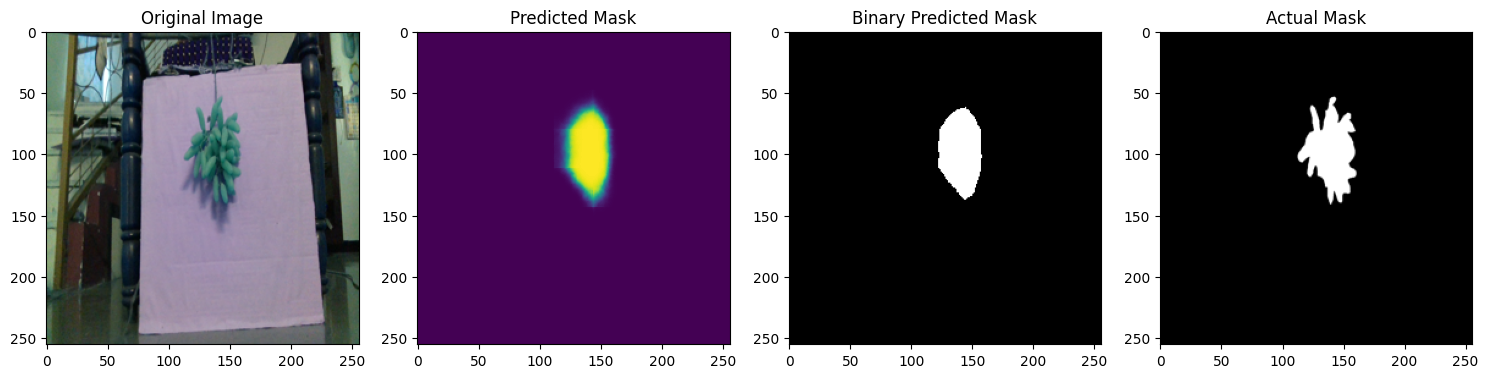

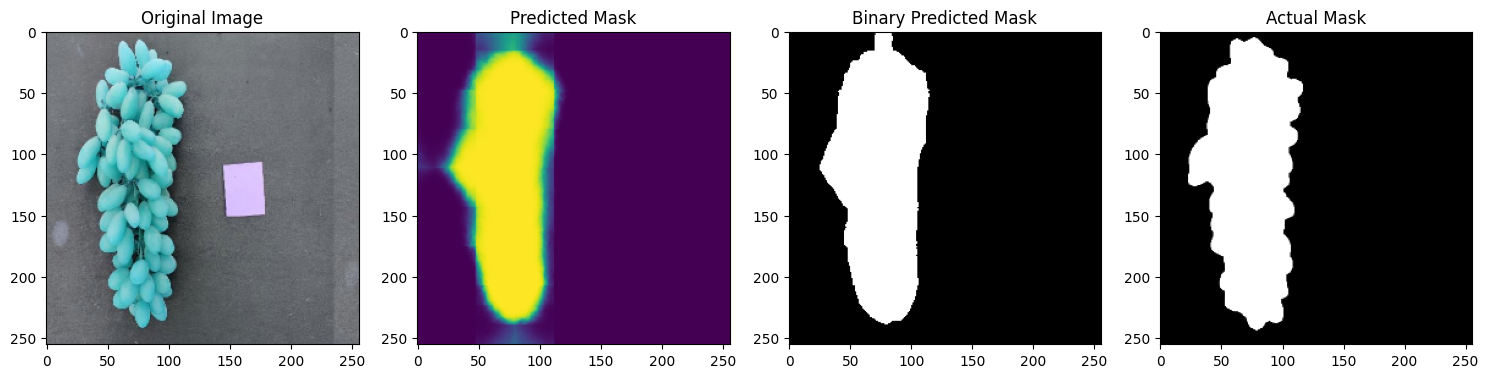

In [23]:
for i in range(10):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [24]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.8269517096929081
Dice Coefficient: 0.9180861864417159


In [25]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.08191381355828409
Focal Loss: 0.11958122663735667


In [26]:
def compute_binary_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

binary_accuracy = compute_binary_accuracy(pred_mask, masks_test)
print("Accuracy:", binary_accuracy)

Accuracy: 0.9615530910262142
